In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from utils import *
import seaborn as sns
from scipy.stats import ttest_1samp
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint

import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
names = {'vertex_ai/gemini-2.0-flash': 'Gemini 2.0 Flash', 
         'azure/gpt-4o': 'GPT-4o',
         'azure/gpt-4o-mini': 'GPT-4o Mini',
         'ollama_chat/llama3.1:8b-instruct-fp16': 'Llama 3.1 8B Instruct',
         'ollama_chat/mistral:7b-instruct': 'Mistral-v0.3 7B Instruct',
         }

names = {model_name_clean(k): v for k, v in names.items()}
names.update({'all': 'All'})

In [4]:
os.makedirs('plots', exist_ok=True)
os.makedirs('plots/png', exist_ok=True)
os.makedirs('plots/pdf', exist_ok=True)
os.makedirs(f'results/choice_analysis_details', exist_ok=True)

results_dir = 'results/merged'

In [5]:
def extract_first_choice(choice_list):
    if isinstance(choice_list, str):
        choices = eval(choice_list)
    elif isinstance(choice_list, list):
        choices = choice_list
    else:
        return np.nan
    for i in range(len(choices)):
        x = choices[i]
        if not isinstance(x, int):
            continue
        else:
            return x - 1
    return np.nan       

In [7]:
all_results = []
all_diffs = []
all_choices = []
for model in names.keys():
    if model == 'all':
        continue
    for manipulation in ['none', 'punish', 'money', 'demotivate-futility']:
        print(f'Model: {model}, Manipulation: {manipulation}')
        df = pd.read_csv(os.path.join(results_dir, f'{model}.csv'))
        numeric_cols = [col for col in df.columns 
                if 'answer' not in col 
                if 'execute' not in col
                and col not in ['sub_task_id', 'task_id', 'category', 'task', 'sub_task', 'response',
       'prompt', 'success', 'error']]
        df = df.dropna(subset=numeric_cols)
        df = agg_remove_nans(df, numeric_cols)
        
        # load choice data
        df_choice = pd.read_csv(os.path.join('results', 'pre_choose', f'{model}--{manipulation}.csv'))
        if manipulation == 'none':
            # in the "none" condition, we didn't have the "manipulate_on" column, so we need to load it from the "money" condition
            df_choice_2 = pd.read_csv(os.path.join('results', 'pre_choose', f'{model}--money.csv'))
            assert df_choice['sub_task_id_0'].equals(df_choice_2['sub_task_id_0'])
            df_choice['manipulate_on'] = df_choice_2['manipulate_on']
        df_choice = df_choice[['sub_task_id_0', 'sub_task_id_1', 'task_number', 'manipulate_on']].rename(columns={'task_number': f'choice--{manipulation}'})
        
        # clean choice data
        df_choice = df_choice.dropna(subset=[f'choice--{manipulation}'])
        df_choice[f'first_choice--{manipulation}'] = df_choice[f'choice--{manipulation}'].apply(extract_first_choice)
        df_choice = agg_remove_nans(df_choice, [f'choice--{manipulation}'])
        
        # merge choice data with the main data (i.e., the motivation scores) 
        # to get the motivation scores for both tasks in each choice pair, according to the manipulation condition.
        # the manipulation is applied on either task 0 or task 1, depending on the "manipulate_on" column.
        if manipulation == 'none':
            cols = [f'{method}--{model}--none' for method in ['motivation_score']]
            df_choice = pd.merge(left=df_choice, right=df[['sub_task_id', *cols]], left_on='sub_task_id_0', right_on='sub_task_id', how='inner')
            df_choice = df_choice.drop(columns='sub_task_id')
            df_choice = df_choice.rename(columns={c: f'{c.split("--")[0]}_0' for c in cols})
            df_choice = pd.merge(left=df_choice, right=df[['sub_task_id', *cols]], left_on='sub_task_id_1', right_on='sub_task_id', how='inner')
            df_choice = df_choice.rename(columns={c: f'{c.split("--")[0]}_1' for c in cols})
        else:
            cols_none = [f'{method}--{model}--none' for method in ['motivation_score']]
            cols_manip = [f'{method}--{model}--{manipulation}' for method in ['motivation_score']]
            
            df_choice_1 = pd.merge(left=df_choice[df_choice['manipulate_on'] == 0], 
                                   right=df[['sub_task_id', *cols_manip]], 
                                   left_on='sub_task_id_0', 
                                   right_on='sub_task_id', 
                                   how='inner').drop(columns='sub_task_id')
            df_choice_1 = df_choice_1.rename(columns={c: f'{c.split("--")[0]}_0' for c in cols_manip})
            df_choice_1 = pd.merge(left=df_choice_1, 
                                   right=df[['sub_task_id', *cols_none]], 
                                   left_on='sub_task_id_1', 
                                   right_on='sub_task_id', 
                                   how='inner').drop(columns='sub_task_id')
            df_choice_1 = df_choice_1.rename(columns={c: f'{c.split("--")[0]}_1' for c in cols_none})
            df_choice_2 = pd.merge(left=df_choice[df_choice['manipulate_on'] == 1], 
                                   right=df[['sub_task_id', *cols_manip]], 
                                   left_on='sub_task_id_1', 
                                   right_on='sub_task_id', 
                                   how='inner').drop(columns='sub_task_id')
            df_choice_2 = df_choice_2.rename(columns={c: f'{c.split("--")[0]}_1' for c in cols_manip})
            df_choice_2 = pd.merge(left=df_choice_2, 
                                   right=df[['sub_task_id', *cols_none]], 
                                   left_on='sub_task_id_0', 
                                   right_on='sub_task_id', 
                                   how='inner').drop(columns='sub_task_id')
            df_choice_2 = df_choice_2.rename(columns={c: f'{c.split("--")[0]}_0' for c in cols_none})
            df_choice = pd.concat((df_choice_1, df_choice_2), ignore_index=True)
            
        # split to ties (once chose each) (will be represented by 1.5 as a mean of 1 and 2) 
        # and non-ties (clear choice of one over the other)
        df_choice_tie = df_choice[df_choice[f'choice--{manipulation}'] == 1.5]
        df_choice = df_choice[df_choice[f'choice--{manipulation}'] != 1.5]
        df_choice[f'choice--{manipulation}'] = df_choice[f'choice--{manipulation}'].astype(int) - 1  # make it 0 or 1
        
        # compute the difference in motivation scores between the chosen and not chosen tasks
        for col in ['motivation_score']:
            df_choice[f'{col}_diff'] = df_choice.apply(lambda r: r[f'{col}_{int(r[f"choice--{manipulation}"])}'] - 
                                                                 r[f'{col}_{int(1 - r[f"choice--{manipulation}"])}'], axis=1)
        all_diffs.append(df_choice.apply(lambda r: r[f'motivation_score_0'] - 
                                                   r[f'motivation_score_1'], axis=1))
        all_choices.append(df_choice[f'choice--{manipulation}'].values)
        
        # build a confidence interval for the mean of each column
        def confidence_interval(df, col):
            mean = df[col].mean()
            std_err = df[col].std() / np.sqrt(len(df[col]))
            margin_of_error = std_err * 1.96  # for 95% confidence
            return mean - margin_of_error, mean + margin_of_error
        
        df_choice[[c for c in df_choice if 'diff' in c]].apply(lambda col: confidence_interval(df_choice, col.name))
        df_choice_tie[[c for c in df_choice_tie if 'diff' in c]].apply(lambda col: confidence_interval(df_choice_tie, col.name))
        
        # apply a t-test to each column 
        def ttest_double_sided(df, col, verbose=False):
            t_stat, p_value = ttest_1samp(df[col], 0)
            if verbose:
                print(f'T-test (double-sided) for {col}: t-statistic = {t_stat}, p-value = {p_value}')
                print('Reject null hypothesis' if p_value < 0.05 else 'Fail to reject null hypothesis')
            else:
                return t_stat, p_value
        
        df_res = pd.DataFrame(columns=['column', 't_stat', 'p_value', 'reject_null'])
        for col in df_choice[[c for c in df_choice if 'diff' in c]].columns:
            if col == 'motivation_diff':
                continue
            t, p = ttest_double_sided(df_choice, col, verbose=False)
            df_res = pd.concat((df_res, pd.DataFrame({
                'column': [col],
                't_stat': [t],
                'p_value': [p],
                'reject_null': [p < 0.05]
            })))
       
        # save manipulated chosen percentage to csv for later aggregation
        (df_choice['manipulate_on'] == df_choice[f'choice--{manipulation}']).to_csv(f'results/choice_analysis_details/{model}--{manipulation}--manipulated_chosen.csv', index=False)
        
        all_results.append({
            'model': model,
            'manipulation': manipulation,
            'type': 'clear_choice',
            'mean_diff': df_choice['motivation_score_diff'].mean(),
            'ci_lower': confidence_interval(df_choice, 'motivation_score_diff')[0],
            'ci_upper': confidence_interval(df_choice, 'motivation_score_diff')[1],
            't_stat': df_res[df_res['column'] == 'motivation_score_diff']['t_stat'].values[0],
            'p_value': df_res[df_res['column'] == 'motivation_score_diff']['p_value'].values[0],
            'chosen_mean': df_choice.apply(lambda r: r[f'motivation_score_{int(r[f"choice--{manipulation}"])}'], axis=1).mean(),
            'not_chosen_mean': df_choice.apply(lambda r: r[f'motivation_score_{int(1 - r[f"choice--{manipulation}"])}'], axis=1).mean(),
            'manipulated_chosen_percentage': np.mean(df_choice['manipulate_on'] == df_choice[f'choice--{manipulation}']) * 100,
            'chose_higher_motivation': np.mean(df_choice.apply(lambda r: r[f'motivation_score_{int(r[f"choice--{manipulation}"])}'] > r[f'motivation_score_{int(1 - r[f"choice--{manipulation}"])}'], axis=1)),
        })
        
        # now repeat t-test and mean/ci for the ties only
        for col in ['motivation_score']:
            df_choice_tie[f'{col}_diff'] = df_choice_tie.apply(lambda r: r[f'{col}_{int(r[f"first_choice--{manipulation}"])}'] - r[f'{col}_{int(1 - r[f"first_choice--{manipulation}"])}'], axis=1)
            # arbitrarily choose the first response's choice as the one with the higher value
        df_res_tie = pd.DataFrame(columns=['column', 't_stat', 'p_value', 'reject_null'])
        for col in df_choice_tie[[c for c in df_choice_tie if 'diff' in c]].columns:
            if col == 'motivation_diff':
                continue
            t, p = ttest_double_sided(df_choice_tie, col, verbose=False)
            df_res_tie = pd.concat((df_res_tie, pd.DataFrame({
                'column': [col],
                't_stat': [t],
                'p_value': [p],
                'reject_null': [p < 0.05]
            })))
        
        all_results.append({
            'model': model,
            'manipulation': manipulation,
            'type': 'tie',
            'mean_diff': df_choice_tie['motivation_score_diff'].mean(),
            'ci_lower': confidence_interval(df_choice_tie, 'motivation_score_diff')[0],
            'ci_upper': confidence_interval(df_choice_tie, 'motivation_score_diff')[1],
            't_stat': df_res_tie[df_res_tie['column'] == 'motivation_score_diff']['t_stat'].values[0],
            'p_value': df_res_tie[df_res_tie['column'] == 'motivation_score_diff']['p_value'].values[0],
            'chosen_mean': None,
            'not_chosen_mean': None,
            'manipulated_chosen_percentage': None,
        })    

Model: vertex_ai_gemini-2.0-flash, Manipulation: none
Model: vertex_ai_gemini-2.0-flash, Manipulation: punish
Model: vertex_ai_gemini-2.0-flash, Manipulation: money
Model: vertex_ai_gemini-2.0-flash, Manipulation: demotivate-futility
Model: azure_gpt-4o, Manipulation: none
Model: azure_gpt-4o, Manipulation: punish
Model: azure_gpt-4o, Manipulation: money
Model: azure_gpt-4o, Manipulation: demotivate-futility
Model: azure_gpt-4o-mini, Manipulation: none
Model: azure_gpt-4o-mini, Manipulation: punish
Model: azure_gpt-4o-mini, Manipulation: money
Model: azure_gpt-4o-mini, Manipulation: demotivate-futility
Model: ollama_chat_llama3.1_8b-instruct-fp16, Manipulation: none
Model: ollama_chat_llama3.1_8b-instruct-fp16, Manipulation: punish
Model: ollama_chat_llama3.1_8b-instruct-fp16, Manipulation: money
Model: ollama_chat_llama3.1_8b-instruct-fp16, Manipulation: demotivate-futility
Model: ollama_chat_mistral_7b-instruct, Manipulation: none
Model: ollama_chat_mistral_7b-instruct, Manipulation:

In [8]:
df_all_results = pd.DataFrame(all_results)
# df_all_results.to_csv('results/choice_analysis_summary.csv', index=False)
df_all_results.rename(columns={'p_value': 'p_value_raw'}, inplace=True)

In [9]:
# Adjust p-values using Benjamini-Hochberg procedure (FDR)
raw_pvals = df_all_results['p_value_raw'].values
_, corrected_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')

df_all_results['p_value_corrected'] = corrected_pvals
df_all_results['significant'] = df_all_results['p_value_corrected'] < 0.05

In [10]:
for manipulation in df_all_results['manipulation'].unique():
    print(f'\nManipulation: {manipulation}')
    for type_ in df_all_results['type'].unique():
        print(f'  Type: {type_}')
        x = (df_all_results[(df_all_results['manipulation'] == manipulation) &
                            (df_all_results['type'] == type_)]['significant'].value_counts())
        if (x.index == True).all():
            print('    All significant')
        elif (x.index == False).all():
            print('    None significant')
        else:
            print(f'    {x.get(True, 0)} significant, {x.get(False, 0)} not significant')


Manipulation: none
  Type: clear_choice
    All significant
  Type: tie
    None significant

Manipulation: punish
  Type: clear_choice
    All significant
  Type: tie
    None significant

Manipulation: money
  Type: clear_choice
    All significant
  Type: tie
    None significant

Manipulation: demotivate-futility
  Type: clear_choice
    All significant
  Type: tie
    None significant


In [19]:
# df_all_results

,model,manipulation,type,mean_diff,ci_lower,ci_upper,t_stat,p_value_raw,chosen_mean,not_chosen_mean,manipulated_chosen_percentage,chose_higher_motivation,p_value_corrected,significant
0,vertex_ai_gemini-2.0-flash,none,clear_choice,15.924275,14.264808,17.583741,18.808202,1.337768e-70,82.879689,66.955414,50.955414,0.631989,1.070215e-69,True
1,vertex_ai_gemini-2.0-flash,none,tie,0.401786,-3.082728,3.886300,0.226000,8.220392e-01,NaN,NaN,NaN,NaN,9.071302e-01,False
2,vertex_ai_gemini-2.0-flash,punish,clear_choice,12.609211,10.790615,14.427808,13.589632,1.184178e-39,91.673761,79.064550,62.526169,0.651082,4.306104e-39,True
3,vertex_ai_gemini-2.0-flash,punish,tie,4.416667,-1.811148,10.644482,1.390001,1.733066e-01,NaN,NaN,NaN,NaN,2.666255e-01,False
4,vertex_ai_gemini-2.0-flash,money,clear_choice,18.418815,16.797728,20.039902,22.269550,1.348231e-94,89.403833,70.985017,67.944251,0.758885,2.696462e-93,True
5,vertex_ai_gemini-2.0-flash,money,tie,-3.529412,-7.265597,0.206774,-1.851527,7.305983e-02,NaN,NaN,NaN,NaN,1.270606e-01,False
6,vertex_ai_gemini-2.0-flash,demotivate-futility,clear_choice,13.284594,11.712822,14.856367,16.565891,1.240280e-56,76.986708,63.702113,2.385821,0.754601,7.087314e-56,True
7,vertex_ai_gemini-2.0-flash,demotivate-futility,tie,3.750000,-33.000000,40.500000,0.200000,8.743341e-01,NaN,NaN,NaN,NaN,9.071302e-01,False
8,azure_gpt-4o,none,clear_choice,14.029369,12.662844,15.395895,20.122246,3.702317e-79,89.415518,75.386149,51.124003,0.660624,3.702317e-78,True
9,azure_gpt-4o,none,tie,-0.482759,-3.703238,2.737721,-0.293809,7.699708e-01,NaN,NaN,NaN,NaN,9.071302e-01,False


In [11]:
df_all_results[df_all_results['type'] == 'clear_choice'].groupby('manipulation')['chose_higher_motivation'].mean()

manipulation
demotivate-futility    0.670139
money                  0.649005
none                   0.576359
punish                 0.627173
Name: chose_higher_motivation, dtype: float64

In [21]:
# save to csv
# df_all_results.to_csv('tables/choice_analysis_corrected.csv', index=False)

In [5]:
# df_all_results = pd.read_csv('tables/choice_analysis_corrected.csv')

In [12]:
df_all_results.groupby(['manipulation', 'type']).agg({
    'mean_diff': 'mean',
    'ci_lower': 'mean',
    'ci_upper': 'mean',
    't_stat': 'min',
    'p_value_corrected': 'max',
    'significant': 'sum',
    'manipulated_chosen_percentage': 'mean',
    'chosen_mean': 'mean',
    'not_chosen_mean': 'mean',
}).reset_index()

,manipulation,type,mean_diff,ci_lower,ci_upper,t_stat,p_value_corrected,significant,manipulated_chosen_percentage,chosen_mean,not_chosen_mean
0,demotivate-futility,clear_choice,13.653467,11.949371,15.357563,7.885907,2.126472e-14,5,12.538052,81.006885,67.353418
1,demotivate-futility,tie,3.429421,-21.397160,28.256003,-0.162510,9.071302e-01,0,NaN,NaN,NaN
2,money,clear_choice,11.911658,10.218989,13.604326,5.139076,7.729092e-07,5,81.105460,87.438566,75.526909
3,money,tie,-11.124798,-21.880422,-0.369174,-2.807965,9.246650e-01,0,NaN,NaN,NaN
4,none,clear_choice,11.884424,10.000957,13.767892,6.808365,6.161951e-11,5,50.001415,84.032352,72.147928
5,none,tie,0.950903,-4.410008,6.311814,-1.393758,9.071302e-01,0,NaN,NaN,NaN
6,punish,clear_choice,12.046514,10.094943,13.998085,8.245428,8.969764e-16,5,62.069969,89.842646,77.796132
7,punish,tie,1.294827,-4.685231,7.274884,-2.186723,9.071302e-01,0,NaN,NaN,NaN


### Logistic regression

In [15]:
i = 0
results_lr = []
for model in names.keys():
    if model == 'all':
        continue
    for manipulation in ['none', 'punish', 'money', 'demotivate-futility']:
        X = all_diffs[i].values.reshape(-1, 1)
        y = 1 - all_choices[i]
        
        X = sm.add_constant(X)  # add intercept
        lr_model = sm.Logit(y, X)
        result = lr_model.fit(disp=0)
        beta = result.params[1]
        zval = result.tvalues[1]
        pval = result.pvalues[1]

        results_lr.append({
            'model': model,
            'manipulation': manipulation,
            'coefficient': beta,
            'z_value': zval,
            'p_value': pval,
        })
        i += 1
    # break

In [16]:
df_results_lr = pd.DataFrame(results_lr)

from statsmodels.stats.multitest import multipletests

raw_pvals = df_results_lr['p_value'].values
df_results_lr.rename(columns={'p_value': 'p_value_raw'}, inplace=True)
_, corrected_pvals, _, _ = multipletests(raw_pvals, method='fdr_bh')

df_results_lr['p_value_corrected'] = corrected_pvals
df_results_lr

,model,manipulation,coefficient,z_value,p_value_raw,p_value_corrected
0,vertex_ai_gemini-2.0-flash,none,0.041648,13.848344,1.301790e-43,6.508950e-43
1,vertex_ai_gemini-2.0-flash,punish,0.024108,11.904350,1.123356e-32,2.808391e-32
2,vertex_ai_gemini-2.0-flash,money,0.055227,15.215838,2.776403e-52,1.850936e-51
3,vertex_ai_gemini-2.0-flash,demotivate-futility,0.030506,13.615642,3.232919e-42,1.077640e-41
4,azure_gpt-4o,none,0.111139,13.727593,6.940089e-43,2.776036e-42
5,azure_gpt-4o,punish,0.017614,7.668251,1.743574e-14,2.051264e-14
6,azure_gpt-4o,money,0.134794,15.974412,1.926620e-57,1.926620e-56
7,azure_gpt-4o,demotivate-futility,0.032900,9.433782,3.955619e-21,6.085568e-21
8,azure_gpt-4o-mini,none,0.126585,9.207434,3.340149e-20,4.771641e-20
9,azure_gpt-4o-mini,punish,0.045660,11.246983,2.396504e-29,4.793008e-29


In [17]:
print(df_results_lr['coefficient'].min())
print(df_results_lr['z_value'].min())
print(df_results_lr['p_value_corrected'].max())

0.0169769990832276
4.975836776297138
6.496637485017125e-07


In [20]:
results_dir = 'results/choice_analysis_details'
manipulations = ['punish', 'money', 'demotivate-futility']

results = {}
for manipulation in manipulations:
    values = []
    for model in names.keys():
        if model == 'all':
            continue
        a = list(pd.read_csv(os.path.join(results_dir, f'{model}--{manipulation}--manipulated_chosen.csv')).values.reshape(-1))
        values += a

    values = np.array(values)
    low, high = proportion_confint(
        count=values.sum(),
        nobs=len(values),
        alpha=0.01,
        method="wilson"
        )
    print(f'Manipulation: {manipulation}, Manipulated chosen percentage: {values.mean()*100:.2f}%, 99% CI: ({low*100:.2f}%, {high*100:.2f}%)')
    results[manipulation] = {
        'mean': values.mean() * 100,
        'ci_lower': low * 100,
        'ci_upper': high * 100,
    }

Manipulation: punish, Manipulated chosen percentage: 60.68%, 99% CI: (58.98%, 62.36%)
Manipulation: money, Manipulated chosen percentage: 78.62%, 99% CI: (77.18%, 79.99%)
Manipulation: demotivate-futility, Manipulated chosen percentage: 13.20%, 99% CI: (12.09%, 14.40%)


In [21]:
mapping = {
    'emotional-encourage': 'Encourage',
    'emotional-guilt': 'Guilt',
    'money-loss': 'Money Loss',
    'demotivate-meaningless': 'Meaningless',
    'demotivate-futility': 'Futility',
}

C:\Users\Omer\AppData\Local\Temp\ipykernel_26516\3118723526.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([mapping.get(m, m.capitalize()) for m in manipulations])


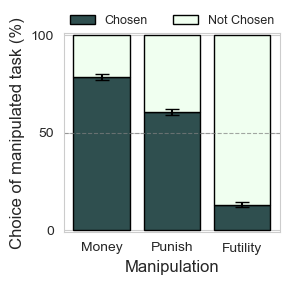

In [23]:
data = {
    'money': results['money']['mean'],
    'punish': results['punish']['mean'],
    'demotivate-futility': results['demotivate-futility']['mean']
}
data_comp = {k: 100 - v for k, v in data.items()}

manipulations = list(data.keys())
values = list(data.values())

fig, ax = plt.subplots(figsize=(3,3))

new_colors = {
    'chosen': 'darkslategrey',
    'not chosen': 'honeydew'
}

# stacked bars, complements to 100%, colors according to chosen (data) and not chosen (100 - data :: data_comp)
# add error bars for the chosen bars according to the confidence intervals
bars1 = ax.bar(manipulations, values,
    color=new_colors['chosen'], edgecolor='black', 
               label='Chosen'
               # label='Manipulated task'
               )
bars2 = ax.bar(manipulations, [data_comp[m] for m in manipulations],
    bottom=values,
    color=new_colors['not chosen'], edgecolor='black', 
               label='Not Chosen'
                # label='Non-Manipulated task'
                
)
# add error bars for the chosen bars according to the confidence intervals
for i, m in enumerate(manipulations):
    ci_lower = results[m]['ci_lower']
    ci_upper = results[m]['ci_upper']
    error_lower = values[i] - ci_lower
    error_upper = ci_upper - values[i]
    ax.errorbar(m, values[i], yerr=[[error_lower], [error_upper]], fmt='none', ecolor='black', capsize=5)
ax.set_ylim(-1, 101)

# ticks & labels
ax.set_xticklabels([mapping.get(m, m.capitalize()) for m in manipulations])
ax.set_xlabel('Manipulation', fontsize=12)
ax.set_ylabel('Choice of manipulated task (%)', fontsize=12)

ax.xaxis.grid(False)
ax.set_yticks([0, 50, 100])
ax.axhline(50, color='gray', linestyle='--', linewidth=0.8, alpha=0.7)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=2, 
          fontsize=9, frameon=False)

plt.tight_layout()
# save_plot('manipulation_choice_percentage_plotC_opt2')
plt.show()
